# 01_preprocessing.ipynb – Extraction MFCC pour prothèse myo-acoustique

Objectifs de ce notebook :

1. Charger la base de données multi-canaux (6 canaux).
2. Comprendre la structure des signaux et le taux d'échantillonnage.
3. Expliquer et implémenter étape par étape le calcul des MFCC :
   - STFT et spectrogramme
   - Mel spectrogramme (0–128 Hz)
   - Log-Mel
   - DCT (MFCC)
   - Coefficients en lignes, fenêtres en colonnes
   - Delta (dynamique)
4. Découper les signaux en fenêtres temporelles.
5. Construire deux jeux de données :
   - X_svm : features agrégées (moyenne + delta) → modèle SVM
   - X_lstm : séquences MFCC temporelles → modèle LSTM
6. Sauvegarder X_svm, y et X_lstm, y pour l'entraînement des modèles.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from tqdm import tqdm

# Répertoires
BASE_DIR = "C:/Users/PC/Documents/Projet 5A/data"  # à adapter si besoin
GESTURE_CLASSES = sorted(os.listdir(BASE_DIR))  # ['HC', 'HO', 'fine_pinch', 'index', 'tripod', ...]

print("Classes de gestes :", GESTURE_CLASSES)

# Mapping label -> entier
label2id = {label: idx for idx, label in enumerate(GESTURE_CLASSES)}
id2label = {v: k for k, v in label2id.items()}

print(label2id)

# Configuration signaux
CHANNELS_TO_USE = ['1', '2', '3', '4', '5', '6']  # colonnes des 6 canaux
SR = 1024  # Hz, déduit de la colonne temps

# Découpage en fenêtres (niveau dataset)
WINDOW_DURATION = 1.0  # secondes
WINDOW_SIZE = int(SR * WINDOW_DURATION)  # 1024 échantillons
HOP_WINDOW = WINDOW_SIZE // 2  # 50% overlap

print("Window size (samples) :", WINDOW_SIZE)


Classes de gestes : ['HC', 'HO', 'fine_pinch', 'index', 'tripod']
{'HC': 0, 'HO': 1, 'fine_pinch': 2, 'index': 3, 'tripod': 4}
Window size (samples) : 1024


          0         1         2         3         4         5         6  \
0  2.445312  0.091892  0.790218  0.448040  0.400168  0.403348 -0.308550   
1  2.446289  0.335584  1.404755  0.828055  0.777469  0.740057 -0.037988   
2  2.447266  0.436264  1.678292  0.933067  0.843519  0.839557 -0.067243   
3  2.448242  0.591629  2.049876  1.212403  1.189440  1.088390 -0.047927   
4  2.449219  0.743484  2.391794  1.362914  1.385521  1.225221 -0.127782   

          7         8  
0 -0.007266 -0.013901  
1 -0.007992 -0.015217  
2 -0.007677 -0.016396  
3 -0.009021 -0.013517  
4 -0.007321 -0.015505  
Shape : (3907, 9)
Δt moyen = 0.000977 s, fs ≈ 1024.00 Hz


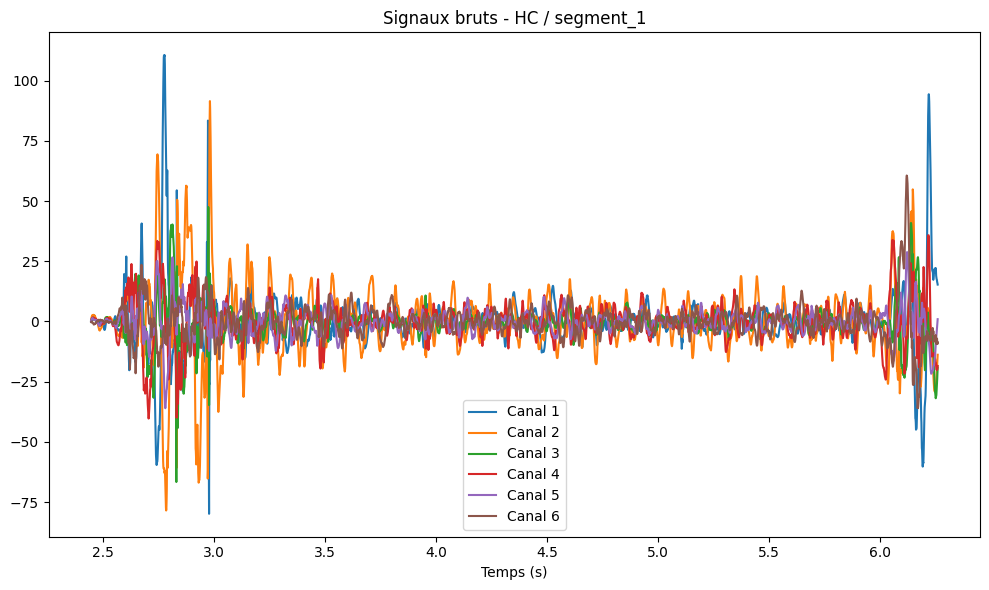

In [3]:
example_class = GESTURE_CLASSES[0]
example_file = os.path.join(BASE_DIR, example_class, "segment_1.csv")

df = pd.read_csv(example_file)
print(df.head())
print("Shape :", df.shape)

time = df['0'].values
signals = df[CHANNELS_TO_USE].values  # shape (N, 6)

# Vérification du sampling rate
dt = np.mean(np.diff(time))
fs_estimated = 1.0 / dt
print(f"Δt moyen = {dt:.6f} s, fs ≈ {fs_estimated:.2f} Hz")

plt.figure(figsize=(10, 6))
for i, ch in enumerate(CHANNELS_TO_USE):
    plt.plot(time, df[ch], label=f"Canal {ch}")
plt.xlabel("Temps (s)")
plt.title(f"Signaux bruts - {example_class} / segment_1")
plt.legend()
plt.tight_layout()
plt.show()


## Théorie rapide : STFT → Mel → Log-Mel → MFCC
""""""
1. **STFT** (Short-Time Fourier Transform)

On découpe le signal en trames de longueur `n_fft` avec chevauchement `hop_length`, on lui applique une fenêtre (ex. Hann), puis on calcule la FFT sur chaque trame :

\[
X(k, n) = \sum_{t=0}^{N-1} x[t + nH] \cdot w[t] \cdot e^{-j 2\pi kt/N}
\]

- \(x[t]\) : signal temporel
- \(w[t]\) : fenêtre (Hann, Hamming, ...)
- \(N = n_\text{fft}\)
- \(H = \text{hop\_length}\)

2. **Spectrogramme de puissance**

\[
S_\text{lin}(k, n) = |X(k,n)|^2
\]

3. **Passage à l'échelle Mel**

On applique une banque de filtres triangulaires \(M(m,k)\) espacés en fréquence Mel :

\[
S_\text{mel}(m, n) = \sum_{k} M(m,k) \cdot S_\text{lin}(k,n)
\]

4. **Log-Mel**

\[
S_\text{log}(m, n) = \log(S_\text{mel}(m,n) + \epsilon)
\]

5. **DCT (MFCC)**

On applique une DCT de type II sur l'axe Mel pour compresser l'information :

\[
\text{MFCC}(c, n) = \sum_{m=0}^{M-1} S_\text{log}(m, n) 
\cos\left[ \frac{\pi}{M} (m + 0.5) c \right]
\]

- \(c\) : indice du coefficient cepstral (0 à \(n_\text{mfcc}-1\))
- MFCC a la forme `(n_mfcc, T)` :
  - **lignes = coefficients**
  - **colonnes = trames temporelles** """"""




MFCC shape : (20, 11)


C:\Users\PC\AppData\Local\Temp\ipykernel_9736\1624186408.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


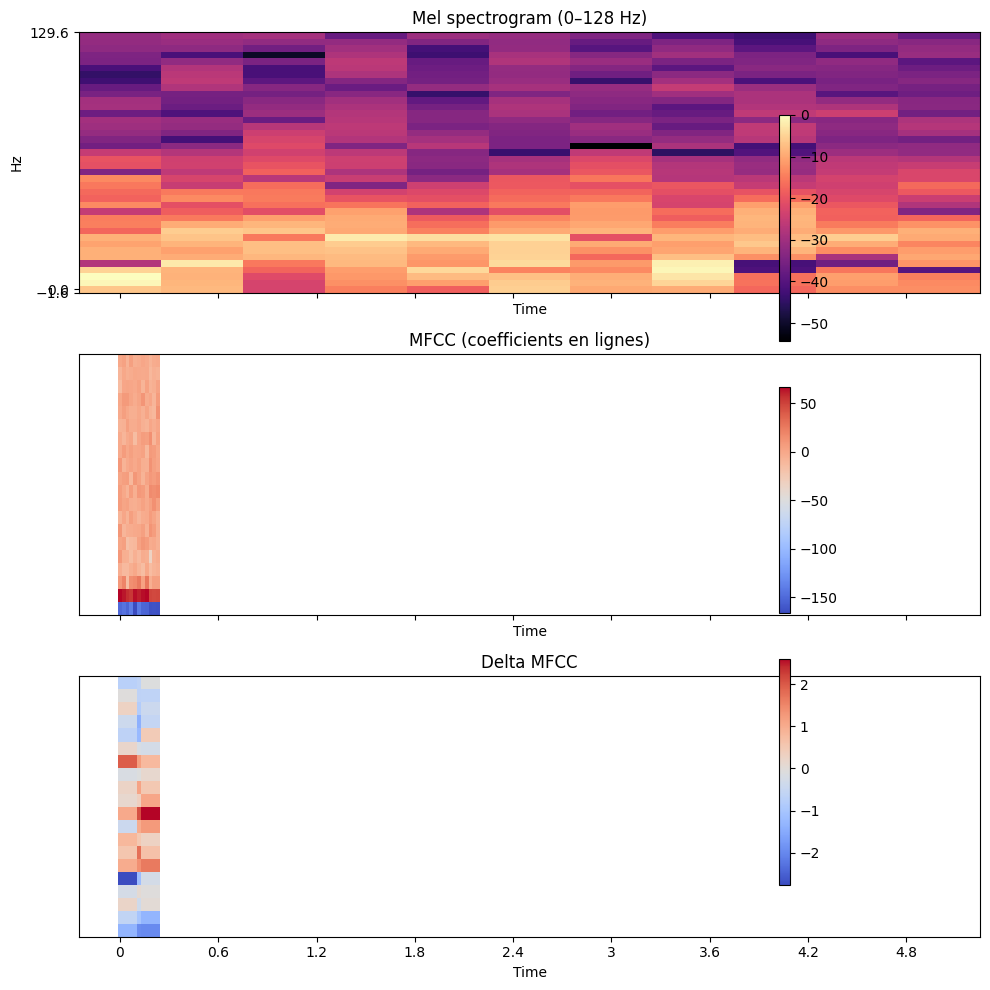

In [25]:
# Paramètres MFCC
N_MFCC = 20
N_MELS = 40
N_FFT = 256
HOP_LENGTH = 128
WIN_LENGTH = N_FFT
FMIN = 0.0
FMAX = 128.0

# On prend un canal pour illustrer (par ex. canal '1')
y = df['1'].values.astype(float)

# STFT
stft = librosa.stft(
    y,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    win_length=WIN_LENGTH,
    window="hann",
    center=True,
    pad_mode="reflect"
)
S_lin = np.abs(stft) ** 2  # spectrogramme de puissance

# Mel spectrogramme
S_mel = librosa.feature.melspectrogram(
    S=S_lin,
    sr=SR,
    n_mels=N_MELS,
    fmin=FMIN,
    fmax=FMAX,
    power=2.0,
    htk=False,
    norm="slaney"
)

# Log-Mel
S_log = librosa.power_to_db(S_mel, ref=np.max)

# MFCC
mfcc = librosa.feature.mfcc(
    S=S_log,
    n_mfcc=N_MFCC,
    dct_type=2,
    norm="ortho",
    lifter=0
)
print("MFCC shape :", mfcc.shape)  # (n_mfcc, T) → coef en lignes, fenêtres en colonnes

# Affichages
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# 1) Mel spectrogramme
img1 = librosa.display.specshow(
    S_log,
    x_axis='time',
    y_axis='mel',
    sr=SR,
    fmin=FMIN,
    fmax=FMAX,
    ax=ax[0]
)
ax[0].set_title("Mel spectrogram (0–128 Hz)")
fig.colorbar(img1, ax=[ax[0]])

# 2) MFCC
img2 = librosa.display.specshow(
    mfcc,
    x_axis='time',
    ax=ax[1]
)
ax[1].set_title("MFCC (coefficients en lignes)")
fig.colorbar(img2, ax=[ax[1]])

# 3) Delta MFCC
delta_mfcc = librosa.feature.delta(mfcc, order=1)
img3 = librosa.display.specshow(
    delta_mfcc,
    x_axis='time',
    ax=ax[2]
)
ax[2].set_title("Delta MFCC")
fig.colorbar(img3, ax=[ax[2]])

plt.tight_layout()
plt.show()


## Agrégation par fenêtre pour SVM

Pour chaque **fenêtre de 1 s** (1024 échantillons) et pour chaque canal :

1. On calcule les MFCC : `mfcc` (forme `(n_mfcc, T)`).
2. On calcule la **moyenne** de chaque coefficient sur toutes les trames :

\[
\mu_k = \frac{1}{T} \sum_{t=1}^T MFCC_{k,t}
\]

3. On calcule les **delta MFCC** (dynamique) puis leur moyenne :

\[
\bar{\Delta}_k = \frac{1}{T} \sum_{t=1}^T \Delta MFCC_{k,t}
\]

4. Pour un canal, on forme le vecteur :

\[
\mathbf{f}_\text{canal} = [\mu_0, \dots, \mu_{19}, \bar{\Delta}_0, \dots, \bar{\Delta}_{19}]
\]

5. Pour 6 canaux, on **concatène** les 6 vecteurs :

\[
\mathbf{f}_\text{fenêtre} = [\mathbf{f}_1, \dots, \mathbf{f}_6] \in \mathbb{R}^{240}
\]

Ce vecteur est l'entrée du modèle **SVM**.


In [6]:
def extract_mfcc_features_one_window(y_channel, sr=SR):
    """
    y_channel : np.ndarray (signal 1D pour un canal sur une fenêtre)
    Retourne :
        - mfcc : (n_mfcc, T)
        - delta_mfcc : (n_mfcc, T)
        - mean_mfcc : (n_mfcc,)
        - mean_delta : (n_mfcc,)
    """
    mfcc = librosa.feature.mfcc(
        y=y_channel.astype(float),
        sr=sr,
        n_mfcc=N_MFCC,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        window="hann",
        center=True,
        pad_mode="reflect",
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX,
        htk=False,
        mel_norm="slaney",
        power=2.0,
        dct_type=2,
        norm="ortho",
        lifter=0
    )
    
    delta = librosa.feature.delta(mfcc, order=1)
    
    mean_mfcc = mfcc.mean(axis=1)
    mean_delta = delta.mean(axis=1)
    
    return mfcc, delta, mean_mfcc, mean_delta


In [22]:
X_svm = []
X_lstm = []   # séquences MFCC pour LSTM
y_all = []

for gesture in GESTURE_CLASSES:
    gesture_dir = os.path.join(BASE_DIR, gesture)
    files = [f for f in os.listdir(gesture_dir) if f.endswith(".csv")]
    
    print(f"Traitement classe '{gesture}' ({len(files)} fichiers)")
    
    for fname in tqdm(files):
        path = os.path.join(gesture_dir, fname)
        df = pd.read_csv(path)
        
        time = df['0'].values
        signals = df[CHANNELS_TO_USE].values  # shape (N_samples, 6)
        n_samples = signals.shape[0]
        
        start = 0
        while start + WINDOW_SIZE <= n_samples:
            end = start + WINDOW_SIZE
            window_data = signals[start:end, :]  # (window_size, 6)
            
            # ---- Features SVM (agrégées) ----
            features_window_svm = []
            
            # ---- Features LSTM (on fera (T, 6 * n_mfcc)) ----
            mfcc_channels = []
            
            for ch_idx in range(len(CHANNELS_TO_USE)):
                y_ch = window_data[:, ch_idx]
                
                mfcc, delta, mean_mfcc, mean_delta = extract_mfcc_features_one_window(
                    y_ch, sr=SR
                )
                
                # Pour SVM : concat des moyens de chaque canal
                features_window_svm.append(mean_mfcc)
                features_window_svm.append(mean_delta)
                
                # Pour LSTM : on concatène mfcc de tous les canaux sur l'axe des features
                # On garde MFCC simple (sans delta) pour commencer
                mfcc_channels.append(mfcc)  # (n_mfcc, T)
            
            # concat SVM features (6 canaux, mfcc + delta)
            features_window_svm = np.concatenate(features_window_svm, axis=0)  # (240,)
            X_svm.append(features_window_svm)
            
            # Pour LSTM :
            # mfcc_channels : liste de 6 matrices (n_mfcc, T)
            # On concatène sur l'axe des coefficients : (6 * n_mfcc, T)
            mfcc_concat = np.concatenate(mfcc_channels, axis=0)  # (6*n_mfcc, T)
            # Puis on transpose pour avoir (T, 6*n_mfcc)
            mfcc_seq = mfcc_concat.T
            X_lstm.append(mfcc_seq)
            
            # Label
            y_all.append(label2id[gesture])
            
            # Fenêtre suivante (avec overlap)
            start += HOP_WINDOW

X_svm = np.stack(X_svm, axis=0)  # shape (N_windows, 240)
X_lstm = np.stack(X_lstm, axis=0)  # shape (N_windows, T_frames, 6*n_mfcc)
y_all = np.array(y_all)

print("X_svm shape :", X_svm.shape)
print("X_lstm shape :", X_lstm.shape)
print("y shape     :", y_all.shape)


Traitement classe 'HC' (100 fichiers)


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Traitement classe 'HO' (100 fichiers)


100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


Traitement classe 'fine_pinch' (100 fichiers)


100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Traitement classe 'index' (100 fichiers)


100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


Traitement classe 'tripod' (100 fichiers)


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]

X_svm shape : (3084, 240)
X_lstm shape : (3084, 9, 120)
y shape     : (3084,)


In [16]:
#Sauvegarde du dataset SVM (1 fichier CSV)
import pandas as pd
import os

os.makedirs("preprocessed_csv", exist_ok=True)

# Sauvegarde CSV SVM : X_svm + label dans 1 seul fichier
df_svm = pd.DataFrame(X_svm)
df_svm["label"] = y_all
df_svm.to_csv("C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/X_svm.csv", index=False)

print("✔ X_svm.csv enregistré !")

✔ X_svm.csv enregistré !


In [17]:
#Sauvegarde du dataset LSTM (1 CSV par fenêtre)
os.makedirs("lstm", exist_ok=True)

for i, seq in enumerate(X_lstm):
    df_seq = pd.DataFrame(seq)  # seq = matrice (T_frames, 6*n_mfcc)
    df_seq.to_csv(f"C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/Labels/window_{i:05d}.csv", index=False)

print("✔ Séquences LSTM enregistrées dans preprocessed_csv/lstm/")


✔ Séquences LSTM enregistrées dans preprocessed_csv/lstm/


In [23]:
#Sauvegarde des labels LSTM
df_lstm_labels = pd.DataFrame({"label": y_all})
df_lstm_labels.to_csv("C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/lstm_labels.csv", index=False)

print("✔ lstm_labels.csv enregistré !")


✔ lstm_labels.csv enregistré !


In [9]:
os.makedirs("preprocessed", exist_ok=True)

np.save("C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/X_svm.csv", X_svm)
np.save("C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/X_lstm.csv", X_lstm)
np.save("C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/y.csv", y_all)

print("Fichiers sauvegardés dans C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets")


Fichiers sauvegardés dans C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets


In [19]:
for g in GESTURE_CLASSES:
    files = [f for f in os.listdir(os.path.join(BASE_DIR, g)) if f.endswith(".csv")]
    print(g, "=>", len(files), "fichiers")


HC => 100 fichiers
HO => 100 fichiers
fine_pinch => 100 fichiers
index => 100 fichiers
tripod => 100 fichiers


In [ ]:
import numpy as np
print("Unique labels :", np.unique(y_all))
print("Count per label:", {lbl: list(y_all).count(lbl) for lbl in np.unique(y_all)})


Unique labels : [0 1 2 3 4]
Count per label: {np.int64(0): 635, np.int64(1): 556, np.int64(2): 646, np.int64(3): 566, np.int64(4): 681}
